In [1]:
import comet_ml
import torch
import os
from torchvision import transforms
from pytorch_lightning.loggers import CometLogger

In [2]:
comet_logger = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    project_name="image_inpainting",
)

CometLogger will be initialized in online mode


In [3]:
import pandas as pd
from inpainting.InpaintingDataset import *
from torch.utils.data import DataLoader

df = pd.read_parquet('local_wikiart.parquet', columns=['title', 'artist', 'date', 'genre', 'style', 'image']).head(5000)

total_len = len(df)
train_len = int(0.8 * total_len)
val_len = int(0.5 * (total_len - train_len))
train_df = df[:train_len].copy(deep=True)
val_df = df[train_len:train_len+val_len].copy(deep=True)
test_df = df[train_len+val_len:].copy(deep=True)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = InpaintingDataset(df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
val_dataset = InpaintingDataset(df, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=10)
test_dataset = InpaintingDataset(df, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=10)

torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


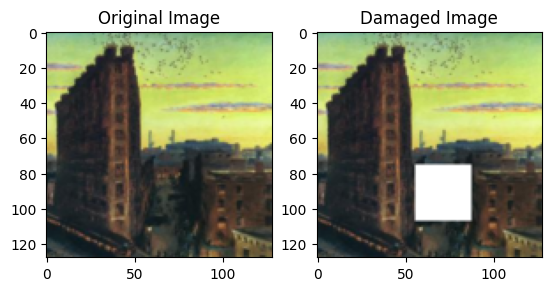

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

damaged_img, original_img = train_dataset[0]
damaged_img = damaged_img[:3, :, :]
print(damaged_img.shape, original_img.shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Original Image")
ax1.imshow(original_img.permute(1, 2, 0))
ax2.set_title("Damaged Image")
ax2.imshow(damaged_img.permute(1, 2, 0))
plt.show()

In [5]:
from inpainting.InpaintingGAN import *

generator = Generator()
discriminator = Discriminator()
model = GANInpainting(generator, discriminator)

/home/aneta/Documents/UNN/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
/home/aneta/Documents/UNN/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.


In [6]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = Trainer(
        logger=comet_logger,
        max_epochs=50,
        accelerator="gpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(monitor="g_loss", save_top_k=1, mode="min", filename="gan-inpainting-{epoch:02d}-{g_loss:.2f}"),
            #EarlyStopping('val_loss')
        ]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
torch.set_float32_matmul_precision('medium')

In [8]:
# from torchinfo import summary
# summary(model.generator, input_size=(4, 128, 128))
# summary(model.discriminator, input_size=(3, 128, 128))

In [ ]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/anekil/image-inpainting/ac7c996631ed48039f6d7d1b10970667

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | generator           | Generator         | 3.1 M  | train
1 | discriminator       | Discriminator     | 11.3 M | train
2 | adversarial_loss    | BCEWithLogitsLoss | 0      | train
3 | reconstruction_loss | L1Loss            | 0      | train
------------------------------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.640    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.test(model, dataloaders=test_dataloader)